In [1]:
import pandas as pd
import numpy as np
import argparse
import itertools
import matplotlib.pyplot as plt

import re
import os
from os import path
import sys
import time

In [2]:
ms= {
    'EbbRT-Node1': 'v',
    'Linux-Node1': 'x',
    'Linux-Node2': '*',
    'Linux-Node3': 'o',
}

df_dict = {
    'qps': [],
    'i' : [],
    'ins': [],
    'cyc': [],
    'refcyc': [],
    'joules': [],
    'tail': [],
}

def resetdict():
    for key in df_dict:
        df_dict[key] = []

def parseLat(s):
    with open(s) as file:
        for line in file:
            if 'read' in line:
                return float((line.strip().split())[9])

## EbbRT C220G1

In [4]:
qps=0
i=0
with open("c220g1/silo/results.md") as file:
    for line in file:        
        ins=0
        cyc=0
        refcyc=0
        joules=0.0
        if "MQPS" in line.strip():
            qps = int(line.strip().split(' ')[2])
            i = 0
        elif "[STATS ALL]" in line.strip():            
            tmp = line.strip().split(' ')
            #print(tmp)
            ins = int(tmp[2])
            cyc = int(tmp[3])
            refcyc = int(tmp[4])
            joules = float(tmp[5])

            df_dict['qps'].append(qps)
            df_dict['i'].append(i)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(parseLat(f"c220g1/silo/ebbrtbm_silo_qps{qps}_iter{i}.out"))
            i += 1
df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dfebbrt = df.groupby(['qps']).mean()
dfebbrt['type'] = type
dfebbrt['ipc'] = dfebbrt['ins']/dfebbrt['refcyc']
dfebbrt=dfebbrt.drop(columns=['i'])
dfebbrt['qps'] = qpss
dfebbrt['kqps']=[int(x / 1000) for x in qpss]
dfebbrt['type']='EbbRT-Node1'
print(dfebbrt)

dfebbrtstd = df.groupby(['qps']).std()
dfebbrtstd['qps']=qpss
maxerr=0.0
for mqps in range(100000, 500000, 100000):
    for metric in ['ins', 'cyc', 'refcyc', 'joules']:
        meanm=round(float(dfebbrt[(dfebbrt['qps'] == mqps)][metric]), 2)
        stdm=round(float(dfebbrtstd[(dfebbrtstd['qps'] == mqps)][metric]),2)
        #print(mqps, metric, meanm, stdm, round((stdm/meanm)*100.0, 2))
        maxerr=max(maxerr, round((stdm/meanm)*100.0, 2))
print(f"Largest error in dfebbrt was {maxerr}% of mean")

                 ins           cyc        refcyc       joules        tail  \
qps                                                                         
100000  2.260118e+11  2.033328e+11  1.991939e+11  1802.183333  200.766667   
200000  4.506124e+11  3.954283e+11  3.797036e+11  2009.243333  241.800000   
300000  6.757110e+11  5.847277e+11  5.608119e+11  2259.073333  302.800000   
400000  9.009332e+11  7.680198e+11  7.365544e+11  2451.133333  431.000000   
500000  1.125656e+12  9.458028e+11  9.070435e+11  2642.900000  867.300000   

               type       ipc     qps  kqps  
qps                                          
100000  EbbRT-Node1  1.134632  100000   100  
200000  EbbRT-Node1  1.186748  200000   200  
300000  EbbRT-Node1  1.204880  300000   300  
400000  EbbRT-Node1  1.223173  400000   400  
500000  EbbRT-Node1  1.241017  500000   500  
Largest error in dfebbrt was 0.89% of mean


## Linux C220G1

In [6]:
## Overheads
resetdict()
ins_oh_arr=[]
cyc_oh_arr=[]
refcyc_oh_arr=[]
joules_oh_arr=[]

ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0
for i in range (0, 4):    
    with open(f"c220g1/linux_silo/PerfStat.Ins.Overhead.linux_silo_iter{i}") as file:
        for line in file:      
            if 'instructions' in line:
                ins_oh_arr.append(int((line.strip().split(','))[0]))
            elif "ref-cycles" in line:
                refcyc_oh_arr.append(int((line.strip().split(','))[0]))
            elif 'cycles' in line:
                cyc_oh_arr.append(int((line.strip().split(','))[0]))
    with open(f"c220g1/linux_silo/PerfStat.Joules.Overhead.linux_silo_iter{i}") as file:
        for line in file:
            if 'Joules' in line:
                joules_oh_arr.append(float((line.strip().split(','))[0]))
ins_oh = np.mean(ins_oh_arr)
cyc_oh = np.mean(cyc_oh_arr)
refcyc_oh = np.mean(refcyc_oh_arr)
joules_oh = np.mean(joules_oh_arr)
            
print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
for mqps in range(100000, 500000, 100000):
    for iter in range(0, 5):
        if os.path.exists(f"c220g1/linux_silo/PerfStat.Ins.linux_silo_mqps{mqps}_iter{iter}") and os.path.exists(f"c220g1/linux_silo/PerfStat.Joules.linux_silo_mqps{mqps}_iter{iter}"):
            ins=0
            cyc=0
            refcyc=0
            joules=0.0
            with open(f"c220g1/linux_silo/PerfStat.Ins.linux_silo_mqps{mqps}_iter{iter}") as file:
                for line in file:  
                    if 'instructions' in line:
                        ins = int((line.strip().split(','))[0]) - ins_oh
                    elif "ref-cycles" in line:
                        refcyc = int((line.strip().split(','))[0]) - cyc_oh
                    elif 'cycles' in line:
                        cyc = int((line.strip().split(','))[0]) - refcyc_oh
            with open(f"c220g1/linux_silo/PerfStat.Joules.linux_silo_mqps{mqps}_iter{iter}") as file:
                for line in file: 
                    if 'Joules' in line:
                        joules = float((line.strip().split(','))[0]) - joules_oh
            tail = parseLat(f"c220g1/linux_silo/linux_silo_mqps{mqps}_iter{iter}.out")
            df_dict['qps'].append(mqps)
            df_dict['i'].append(iter)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(tail)

df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dflinux_c220g1 = df.groupby(['qps']).mean()
dflinux_c220g1['ipc'] = dflinux_c220g1['ins']/dflinux_c220g1['refcyc']
dflinux_c220g1=dflinux_c220g1.drop(columns=['i'])
dflinux_c220g1['qps'] = qpss
dflinux_c220g1['kqps']=[int(x / 1000) for x in qpss]
dflinux_c220g1['type']='Linux-Node1'
print(dflinux_c220g1)

dflinux_c220g1std = df.groupby(['qps']).std()
dflinux_c220g1std['qps']=qpss
maxerr=0.0
for mqps in range(100000, 500000, 100000):
    for metric in ['ins', 'cyc', 'refcyc', 'joules']:
        meanm=round(float(dflinux_c220g1[(dflinux_c220g1['qps'] == mqps)][metric]), 2)
        stdm=round(float(dflinux_c220g1std[(dflinux_c220g1std['qps'] == mqps)][metric]),2)
        #print(mqps, metric, round((stdm/meanm)*100.0, 2))
        maxerr=max(maxerr, round((stdm/meanm)*100.0, 2))
print(f"Largest error in dflinux_c220g1 was {maxerr}% of mean")


176170693774.0 128721866509.0 97777050066.0 1430.04
                 ins           cyc        refcyc     joules       tail  \
qps                                                                      
100000  2.908164e+11  5.726933e+11  4.657972e+11  2007.8700    295.625   
200000  5.478447e+11  1.006666e+12  8.698660e+11  2429.6475    370.475   
300000  7.919115e+11  1.461441e+12  1.288450e+12  2725.0800    712.775   
400000  1.014208e+12  1.878810e+12  1.673696e+12  2954.2800  13758.000   

             ipc     qps  kqps         type  
qps                                          
100000  0.624341  100000   100  Linux-Node1  
200000  0.629804  200000   200  Linux-Node1  
300000  0.614623  300000   300  Linux-Node1  
400000  0.605969  400000   400  Linux-Node1  
Largest error in dflinux_c220g1 was 1.09% of mean


## Linux C220G5

In [9]:
## Overheads
resetdict()
ins_oh_arr=[]
cyc_oh_arr=[]
refcyc_oh_arr=[]
joules_oh_arr=[]

ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0
for i in range (0, 2):    
    with open(f"c220g5/linux_silo/PerfStat.Ins.Overhead.linux_silo_iter{i}") as file:
        for line in file:      
            if 'instructions' in line:
                ins_oh_arr.append(int((line.strip().split(','))[0]))
            elif "ref-cycles" in line:
                refcyc_oh_arr.append(int((line.strip().split(','))[0]))
            elif 'cycles' in line:
                cyc_oh_arr.append(int((line.strip().split(','))[0]))
    with open(f"c220g5/linux_silo/PerfStat.Joules.Overhead.linux_silo_iter{i}") as file:
        for line in file:
            if 'Joules' in line:
                joules_oh_arr.append(float((line.strip().split(','))[0]))
ins_oh = np.mean(ins_oh_arr)
cyc_oh = np.mean(cyc_oh_arr)
refcyc_oh = np.mean(refcyc_oh_arr)
joules_oh = np.mean(joules_oh_arr)
            
print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
for mqps in range(100000, 400000, 100000):
    for iter in range(0, 5):
        if os.path.exists(f"c220g5/linux_silo/PerfStat.Ins.linux_silo_mqps{mqps}_iter{iter}") and os.path.exists(f"c220g5/linux_silo/PerfStat.Joules.linux_silo_mqps{mqps}_iter{iter}"):
            ins=0
            cyc=0
            refcyc=0
            joules=0.0
            with open(f"c220g5/linux_silo/PerfStat.Ins.linux_silo_mqps{mqps}_iter{iter}") as file:
                for line in file:  
                    if 'instructions' in line:
                        ins = int((line.strip().split(','))[0]) - ins_oh
                    elif "ref-cycles" in line:
                        refcyc = int((line.strip().split(','))[0]) - cyc_oh
                    elif 'cycles' in line:
                        cyc = int((line.strip().split(','))[0]) - refcyc_oh
            with open(f"c220g5/linux_silo/PerfStat.Joules.linux_silo_mqps{mqps}_iter{iter}") as file:
                for line in file: 
                    if 'Joules' in line:
                        joules = float((line.strip().split(','))[0]) - joules_oh
            tail = parseLat(f"c220g5/linux_silo/linux_silo_mqps{mqps}_iter{iter}.out")
            df_dict['qps'].append(mqps)
            df_dict['i'].append(iter)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(tail)

df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dflinux_c220g5 = df.groupby(['qps']).mean()
dflinux_c220g5['ipc'] = dflinux_c220g5['ins']/dflinux_c220g5['refcyc']
dflinux_c220g5=dflinux_c220g5.drop(columns=['i'])
dflinux_c220g5['qps'] = qpss
dflinux_c220g5['kqps']=[int(x / 1000) for x in qpss]
dflinux_c220g5['type']='Linux-Node2'
print(dflinux_c220g5)

dflinux_c220g5std = df.groupby(['qps']).std()
dflinux_c220g5std['qps']=qpss
maxerr=0.0
for mqps in range(100000, 400000, 100000):
    for metric in ['ins', 'cyc', 'refcyc', 'joules']:
        meanm=round(float(dflinux_c220g5[(dflinux_c220g5['qps'] == mqps)][metric]), 2)
        stdm=round(float(dflinux_c220g5std[(dflinux_c220g5std['qps'] == mqps)][metric]),2)
        print(mqps, metric, meanm, stdm, round((stdm/meanm)*100.0, 2))
        maxerr=max(maxerr, round((stdm/meanm)*100.0, 2))
print(f"Largest error in dflinux_c220g5 was {maxerr}% of mean")


222628275024.5 408425549681.5 359598701616.0 8854.05
                 ins           cyc        refcyc    joules    tail       ipc  \
qps                                                                            
100000  2.908098e+11  5.628346e+11  4.045625e+11  2697.335  297.65  0.718826   
200000  5.490699e+11  1.039135e+12  8.227019e+11  3064.155  383.80  0.667398   
300000  7.914593e+11  1.499348e+12  1.227726e+12  3388.390  585.80  0.644655   

           qps  kqps         type  
qps                                
100000  100000   100  Linux-Node2  
200000  200000   200  Linux-Node2  
300000  300000   300  Linux-Node2  
100000 ins 290809836554.5 234773713.7 0.08
100000 cyc 562834608694.5 4345210712.51 0.77
100000 refcyc 404562473506.5 3830572462.41 0.95
100000 joules 2697.34 22.07 0.82
200000 ins 549069904372.5 1720763712.6 0.31
200000 cyc 1039134756852.0 1224631784.11 0.12
200000 refcyc 822701911574.5 1080880156.06 0.13
200000 joules 3064.16 10.43 0.34
300000 ins 791459324636.5 

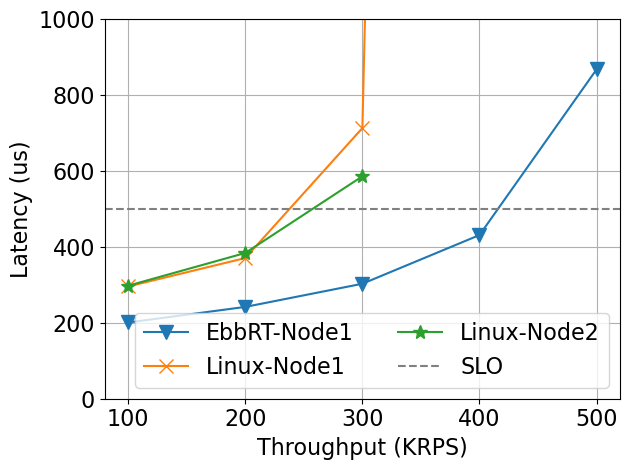

In [10]:
fs=16
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels

# Plot 99 tail
for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5]:
    plt.plot(df['kqps'], df['tail'], marker=ms[str(df['type'].unique()[0])], markersize=10, ls='-', label=str(df['type'].unique()[0]))
plt.axhline(y = 500, color = 'grey', linestyle = '--', label='SLO') 
plt.xlabel("Throughput (KRPS)", fontsize=fs)
plt.ylabel("Latency (us)", fontsize=fs)
plt.ylim(bottom=0, top=1000)
plt.grid()
plt.legend(ncols=2, fontsize=fs)
plt.tight_layout()
plt.show()


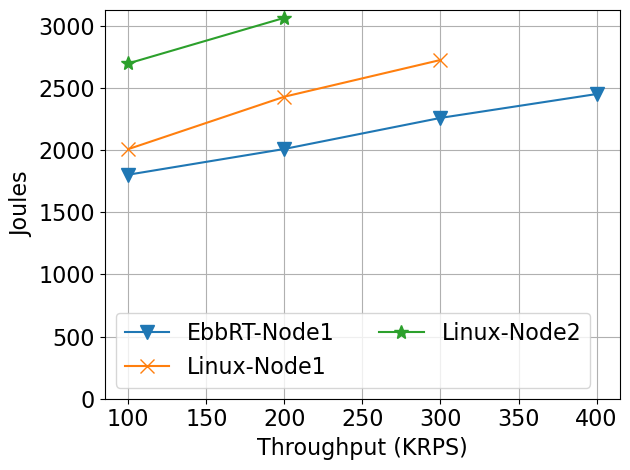

In [11]:
fs=16
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels

for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5]:
    plt.plot(df['kqps'][:-1], df['joules'][:-1], marker=ms[str(df['type'].unique()[0])], markersize=10, ls='-', label=str(df['type'].unique()[0]))
plt.xlabel("Throughput (KRPS)", fontsize=fs)
plt.ylabel("Joules", fontsize=fs)
plt.ylim(bottom=0)
plt.grid()
plt.legend(ncols=2, fontsize=fs)
plt.tight_layout()
plt.show()

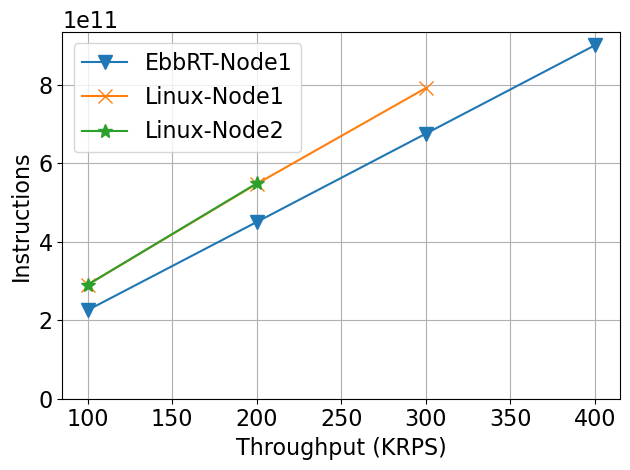

In [12]:
fs=16
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels

for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5]:
    plt.plot(df['kqps'][:-1], df['ins'][:-1], marker=ms[str(df['type'].unique()[0])], markersize=10, ls='-', label=str(df['type'].unique()[0]))
plt.xlabel("Throughput (KRPS)", fontsize=fs)
plt.ylabel("Instructions", fontsize=fs)
plt.ylim(bottom=0)
plt.grid()
plt.legend(ncols=1, fontsize=fs)
plt.tight_layout()
plt.show()

## Linux sm220u

In [ ]:
## Overheads
resetdict()
ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0
with open(f"sm220u/linux_mcd/PerfStat.Overhead.iter0") as file:
    for line in file:      
        #print(line.strip())
        if 'instructions' in line:
            #print(line)
            ins_oh = int((line.strip().split(','))[0])
        elif "ref-cycles" in line:
            refcyc_oh = int((line.strip().split(','))[0])
        elif 'cycles' in line:
            cyc_oh = int((line.strip().split(','))[0])
        elif 'Joules' in line:
            #print(line)
            joules_oh = float((line.strip().split(','))[0])
            
print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
type='linux_sm220u'
iter=1
for mqps in range(200000, 1400000, 200000):
    ins=0
    cyc=0
    refcyc=0
    joules=0.0
    with open(f"sm220u/linux_mcd/PerfStat.linux_mcd_qps{mqps}_iter{iter}") as file:
        for line in file:  
            if 'instructions' in line:
                ins = int((line.strip().split(','))[0]) - ins_oh
            elif "ref-cycles" in line:
                refcyc = int((line.strip().split(','))[0]) - cyc_oh
            elif 'cycles' in line:
                cyc = int((line.strip().split(','))[0]) - refcyc_oh
            elif 'Joules' in line:
                joules = float((line.strip().split(','))[0]) - joules_oh
    tail = parseLat(f"sm220u/linux_mcd/linux_mcd_qps{mqps}_iter{iter}.out")
    df_dict['type'].append(type)
    df_dict['qps'].append(mqps)
    df_dict['i'].append(iter)
    df_dict['ins'].append(ins)
    df_dict['cyc'].append(cyc)
    df_dict['refcyc'].append(refcyc)
    df_dict['joules'].append(joules)
    df_dict['tail'].append(tail)

dflinux_sm220u = pd.DataFrame(df_dict)
dflinux_sm220u['ipc'] = dflinux_sm220u['ins']/dflinux_sm220u['refcyc']
dflinux_sm220u=dflinux_sm220u.drop(columns=['i'])
dflinux_sm220u

